In [1]:
from torch_geometric.nn import GATConv
from torch_geometric.loader import DataLoader
from sklearn.model_selection import KFold, StratifiedKFold
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, matthews_corrcoef, roc_auc_score, auc
from sklearn.metrics import accuracy_score
import os
import random
from torch.utils import data
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from numpy import interp

In [2]:
epochs = 200
device = torch.device('cuda:0')
batch_size = 64
lr = 0.0001
torch.manual_seed(24)
torch.cuda.manual_seed(24)
df=pd.read_csv('data/y_LS_metabric_cleaned1.csv', sep=',')
Y_array = df['# LS'].values
tensor_Y = torch.from_numpy(Y_array)
X_seq = pd.read_csv('data/X_metabric_cleaned1.csv')
X_seq = np.array(X_seq)
X_seq = torch.from_numpy(X_seq).float()

In [3]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造⼀个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [4]:
class EfficientAttentionModified(nn.Module):
    def __init__(self, in_features, key_channels, head_count, value_channels):
        super().__init__()
        self.in_features = in_features
        self.key_channels = key_channels
        self.head_count = head_count
        self.value_channels = value_channels
        self.gamma = nn.Parameter(torch.zeros(1))
        self.keys = nn.Linear(in_features, key_channels)
        self.queries = nn.Linear(in_features, key_channels)
        self.values = nn.Linear(in_features, value_channels)
        self.reprojection = nn.Linear(value_channels, in_features)

    def forward(self, input_):
        n, seq_len, _ = input_.size() # shape is (64, 1, 30)
        keys = self.keys(input_).view((n, seq_len, self.key_channels))
        queries = self.queries(input_).view(n, seq_len, self.key_channels)
        values = self.values(input_).view((n, seq_len, self.value_channels))
        head_key_channels = self.key_channels // self.head_count
        head_value_channels = self.value_channels // self.head_count
        
        attended_values = []
        for i in range(self.head_count):
            key = torch.softmax(keys[:, :, i * head_key_channels: (i + 1) * head_key_channels], dim=-1)
            query = torch.softmax(queries[:, :, i * head_key_channels: (i + 1) * head_key_channels], dim=-2)
            value = values[:, :, i * head_value_channels: (i + 1) * head_value_channels]
            context = torch.bmm(key, value.transpose(1, 2))
            attended_value = torch.bmm(context, query).view(n, seq_len, head_value_channels)
            attended_values.append(attended_value)

        aggregated_values = torch.cat(attended_values, dim=2)
        reprojected_value = self.reprojection(aggregated_values)
        attention = self.gamma*(reprojected_value) + input_
        
        return attention.squeeze(1)


In [5]:
class PreGNN(nn.Module):
    def __init__(self):
        super(PreGNN, self).__init__()
        self.attention = EfficientAttentionModified(in_features=30, key_channels=64, head_count=4, value_channels=64)
        
        self.fc1 = nn.Linear(35, 64)
        self.fc2 = nn.Linear(128, 64)
        
        
        self.conv1 = GATConv(64, 128)
        self.conv2 = GATConv(64, 30)
        
        self.bn1 = nn.BatchNorm1d(128)
        self.bn2 = nn.BatchNorm1d(30)

        self.mlp_cl = nn.Sequential(nn.Linear(30, 64), nn.ReLU(), nn.Linear(64, 32), nn.ReLU(),
                                    nn.Dropout(), nn.BatchNorm1d(32))
    
        self.fc3 = nn.Linear(64, 2)


    
    def forward(self,data):
        x = data.x
        edge_index = data.edge_index
        batch = data.batch

        seq = data.x_seq.reshape(len(data.y),1,-1)
        # print(seq.shape)
        x_seq = self.attention(seq) # seq shape is (batch,1,30); x_seq shape is (batch,30)

        
        x = self.fc1(x.to(self.fc1.weight.dtype))
        x = self.conv1(x,edge_index)
        x = F.dropout(x, 0.3, training=self.training)
        x = F.relu(x)
        x = self.bn1(x)
        
        x = self.fc2(x)
        x = self.conv2(x,edge_index)
        x = F.dropout(x, 0.3, training=self.training)
        x = F.relu(x)
        x = self.bn2(x)
        
        
        _, counts = torch.unique(batch, return_counts=True)
        counts.to(device)
        # 根据每个图的节点数计算第一个节点的索引
        first_node_indices = torch.cat((torch.zeros(1, dtype=torch.long).to(device), counts.cumsum(0)[:-1]))
    
        x = x[first_node_indices,:]
        
        x_cl = self.mlp_cl(x)
        x_seq_cl = self.mlp_cl(x_seq)

        x = torch.cat([x_cl, x_seq_cl], dim=1)
        x = self.fc3(x)

        
        return x,x_cl,x_seq_cl # 返回中心节点

In [6]:
def xavier_init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv1d:
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.fill_(0)
    elif type(m) == GATConv:
        for name, param in m.named_parameters():
            if "weight" in name:
                nn.init.xavier_uniform_(param)
            elif "bias" in name:
                param.fill_(0)

In [7]:
datalist = [] 
undirected_datalist = torch.load('./data/undirected_datalist.pt')
for data,seq in zip(undirected_datalist,X_seq):
    data.x_seq = seq
    # print(seq.shape)
    datalist.append(data)

In [8]:
def sim(h1, h2):
    z1 = F.normalize(h1, dim=-1, p=2)
    z2 = F.normalize(h2, dim=-1, p=2)
    return torch.mm(z1, z2.t())

def contrastive_loss_cross_view(h1, h2):
    f = lambda x: torch.exp(x)
    cross_sim = f(sim(h1, h2))
    return -torch.log(cross_sim.diag() / cross_sim.sum(dim=-1))

In [10]:
SKF = StratifiedKFold(n_splits=5, random_state=24, shuffle=True)
acc = 0.0
f1 = 0.0
pre = 0.0
recall = 0.0
c_index = 0.0
ks = 5
for index, (train, test) in enumerate(SKF.split(datalist, tensor_Y)):
    train_set = [datalist[i] for i in train]
    test_set =  [datalist[i] for i in test]
    train_loader = DataLoader(train_set, shuffle = True, batch_size=batch_size)
    test_loader = DataLoader(test_set, shuffle = True, batch_size=batch_size)
    torch.save(test_set, f'metabric/1/X_test_{index}.pkl')
    
    model = PreGNN()
    model.to(device)
    # model.apply(xavier_init_weights)
    model.train()
    weight_decay = 5e-3
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)  # betas=(0.5, 0.999)
    criterion = nn.CrossEntropyLoss()

    score = 0.0
    acc_best = 0.0
    pre_best = 0.0
    recall_best = 0.0
    c_index_best = 0.0
    f1_best = 0.0
    with open('metabric/1/evaluation_results.txt', 'a') as file:
        print(f"第 {index} 折!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        file.write(f"第 {index} 折!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\n")

        # 训练过程
        for i in range(epochs):
            for batch in train_loader:
                batch.to(device)
                # print(batch.x_seq)
                y_pre,x_cl,x_seq_cl = model(batch)
                cmc_loss = 0.5 * contrastive_loss_cross_view(x_cl, x_seq_cl) + 0.5 * contrastive_loss_cross_view(x_seq_cl, x_cl)
                cmc_loss = cmc_loss.mean()
                cls_loss = criterion(y_pre, batch.y.long())
                loss = cls_loss + cmc_loss
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # 评估过程
            model.eval()
            y_true = []
            y_pred = []
            y_prob = []
            
            with torch.no_grad():
                for batch in test_loader:
                    batch = batch.to(device)
                    y_pre,_,_ = model(batch)
                    y_pre.cpu().detach()
                    fake_pred = torch.argmax(y_pre, dim=1)
                    fake_prob = y_pre[:, 1].view(-1)
    
                    y_true.extend(batch.y.cpu().numpy())
                    y_pred.extend(fake_pred.cpu().numpy())
                    y_prob.extend(fake_prob.cpu().numpy())
    
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            y_prob = np.array(y_prob)
    
            # 进行评估
            score_ = matthews_corrcoef(y_true, y_pred)
            acc_ = accuracy_score(y_true, y_pred)
            f1_ = f1_score(y_true, y_pred)
            pre_ = precision_score(y_true, y_pred)
            recall_ = recall_score(y_true, y_pred)
            
            if score_ > score:
                score = score_
                acc_best = acc_
                pre_best = pre_
                recall_best = recall_
                f1_best = f1_
    
                c_index_best = roc_auc_score(y_true, y_pred)
                torch.save(y_true, f'metabric/1/train_data/yt{index + 1}.pkl')
                torch.save(y_prob, f'metabric/1/train_data/fake_prob{index + 1}.pkl')
                torch.save(y_pred, f'metabric/1/train_data/fake_pred{index + 1}.pkl')
                        # 打印并保存到文件
            results = (
                f"accuracy_score: {acc_}\n"
                f"f1_score: {f1_}\n"
                f"precision_score: {pre_}\n"
                f"recall_score: {recall_}\n"
                "---------------------------------------------\n"
                f"acc {index + 1}: {acc_best}\n"
                f"pre {index + 1}: {pre_best}\n"
                f"recall {index + 1}: {recall_best}\n"
                f"f1 {index + 1}: {f1_best}\n"
                f"c_index {index + 1}: {c_index_best}\n"
                "--=--=-=-==-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-\n"
            )
            # print(results)
            file.write(results)
            print("-------------------------------------")
            print(f'acc {index + 1}:', acc_best)
            print(f'pre {index + 1}:', pre_best)
            print(f'recall {index + 1}:', recall_best)
            print(f'f1 {index + 1}:', f1_best)
            print(f'c_index {index + 1}:', c_index_best)
            print("-------------------------------------")
    acc += acc_best
    f1 += f1_best
    pre += pre_best
    recall += recall_best
    c_index += c_index_best

print('acc: ', acc / 5)
print('pre: ', pre / 5)
print('recall: ', recall / 5)
print('f1: ', f1 / 5)
print('c_index: ', c_index / 5)

第 0 折!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
-------------------------------------
acc 1: 0.8080808080808081
pre 1: 0.9625
recall 1: 0.7751677852348994
f1 1: 0.8587360594795539
c_index 1: 0.841665525270511
-------------------------------------
-------------------------------------
acc 1: 0.8080808080808081
pre 1: 0.9625
recall 1: 0.7751677852348994
f1 1: 0.8587360594795539
c_index 1: 0.841665525270511
-------------------------------------
-------------------------------------
acc 1: 0.8863636363636364
pre 1: 0.9041533546325878
recall 1: 0.9496644295302014
f1 1: 0.9263502454991818
c_index 1: 0.8217709902753048
-------------------------------------
-------------------------------------
acc 1: 0.9015151515151515
pre 1: 0.9450171821305842
recall 1: 0.9228187919463087
f1 1: 0.9337860780984719
c_index 1: 0.8797767429119299
-------------------------------------
-------------------------------------
acc 1: 0.9065656565656566
pre 1: 0.9578947368421052
recall 1: 0.916107382550

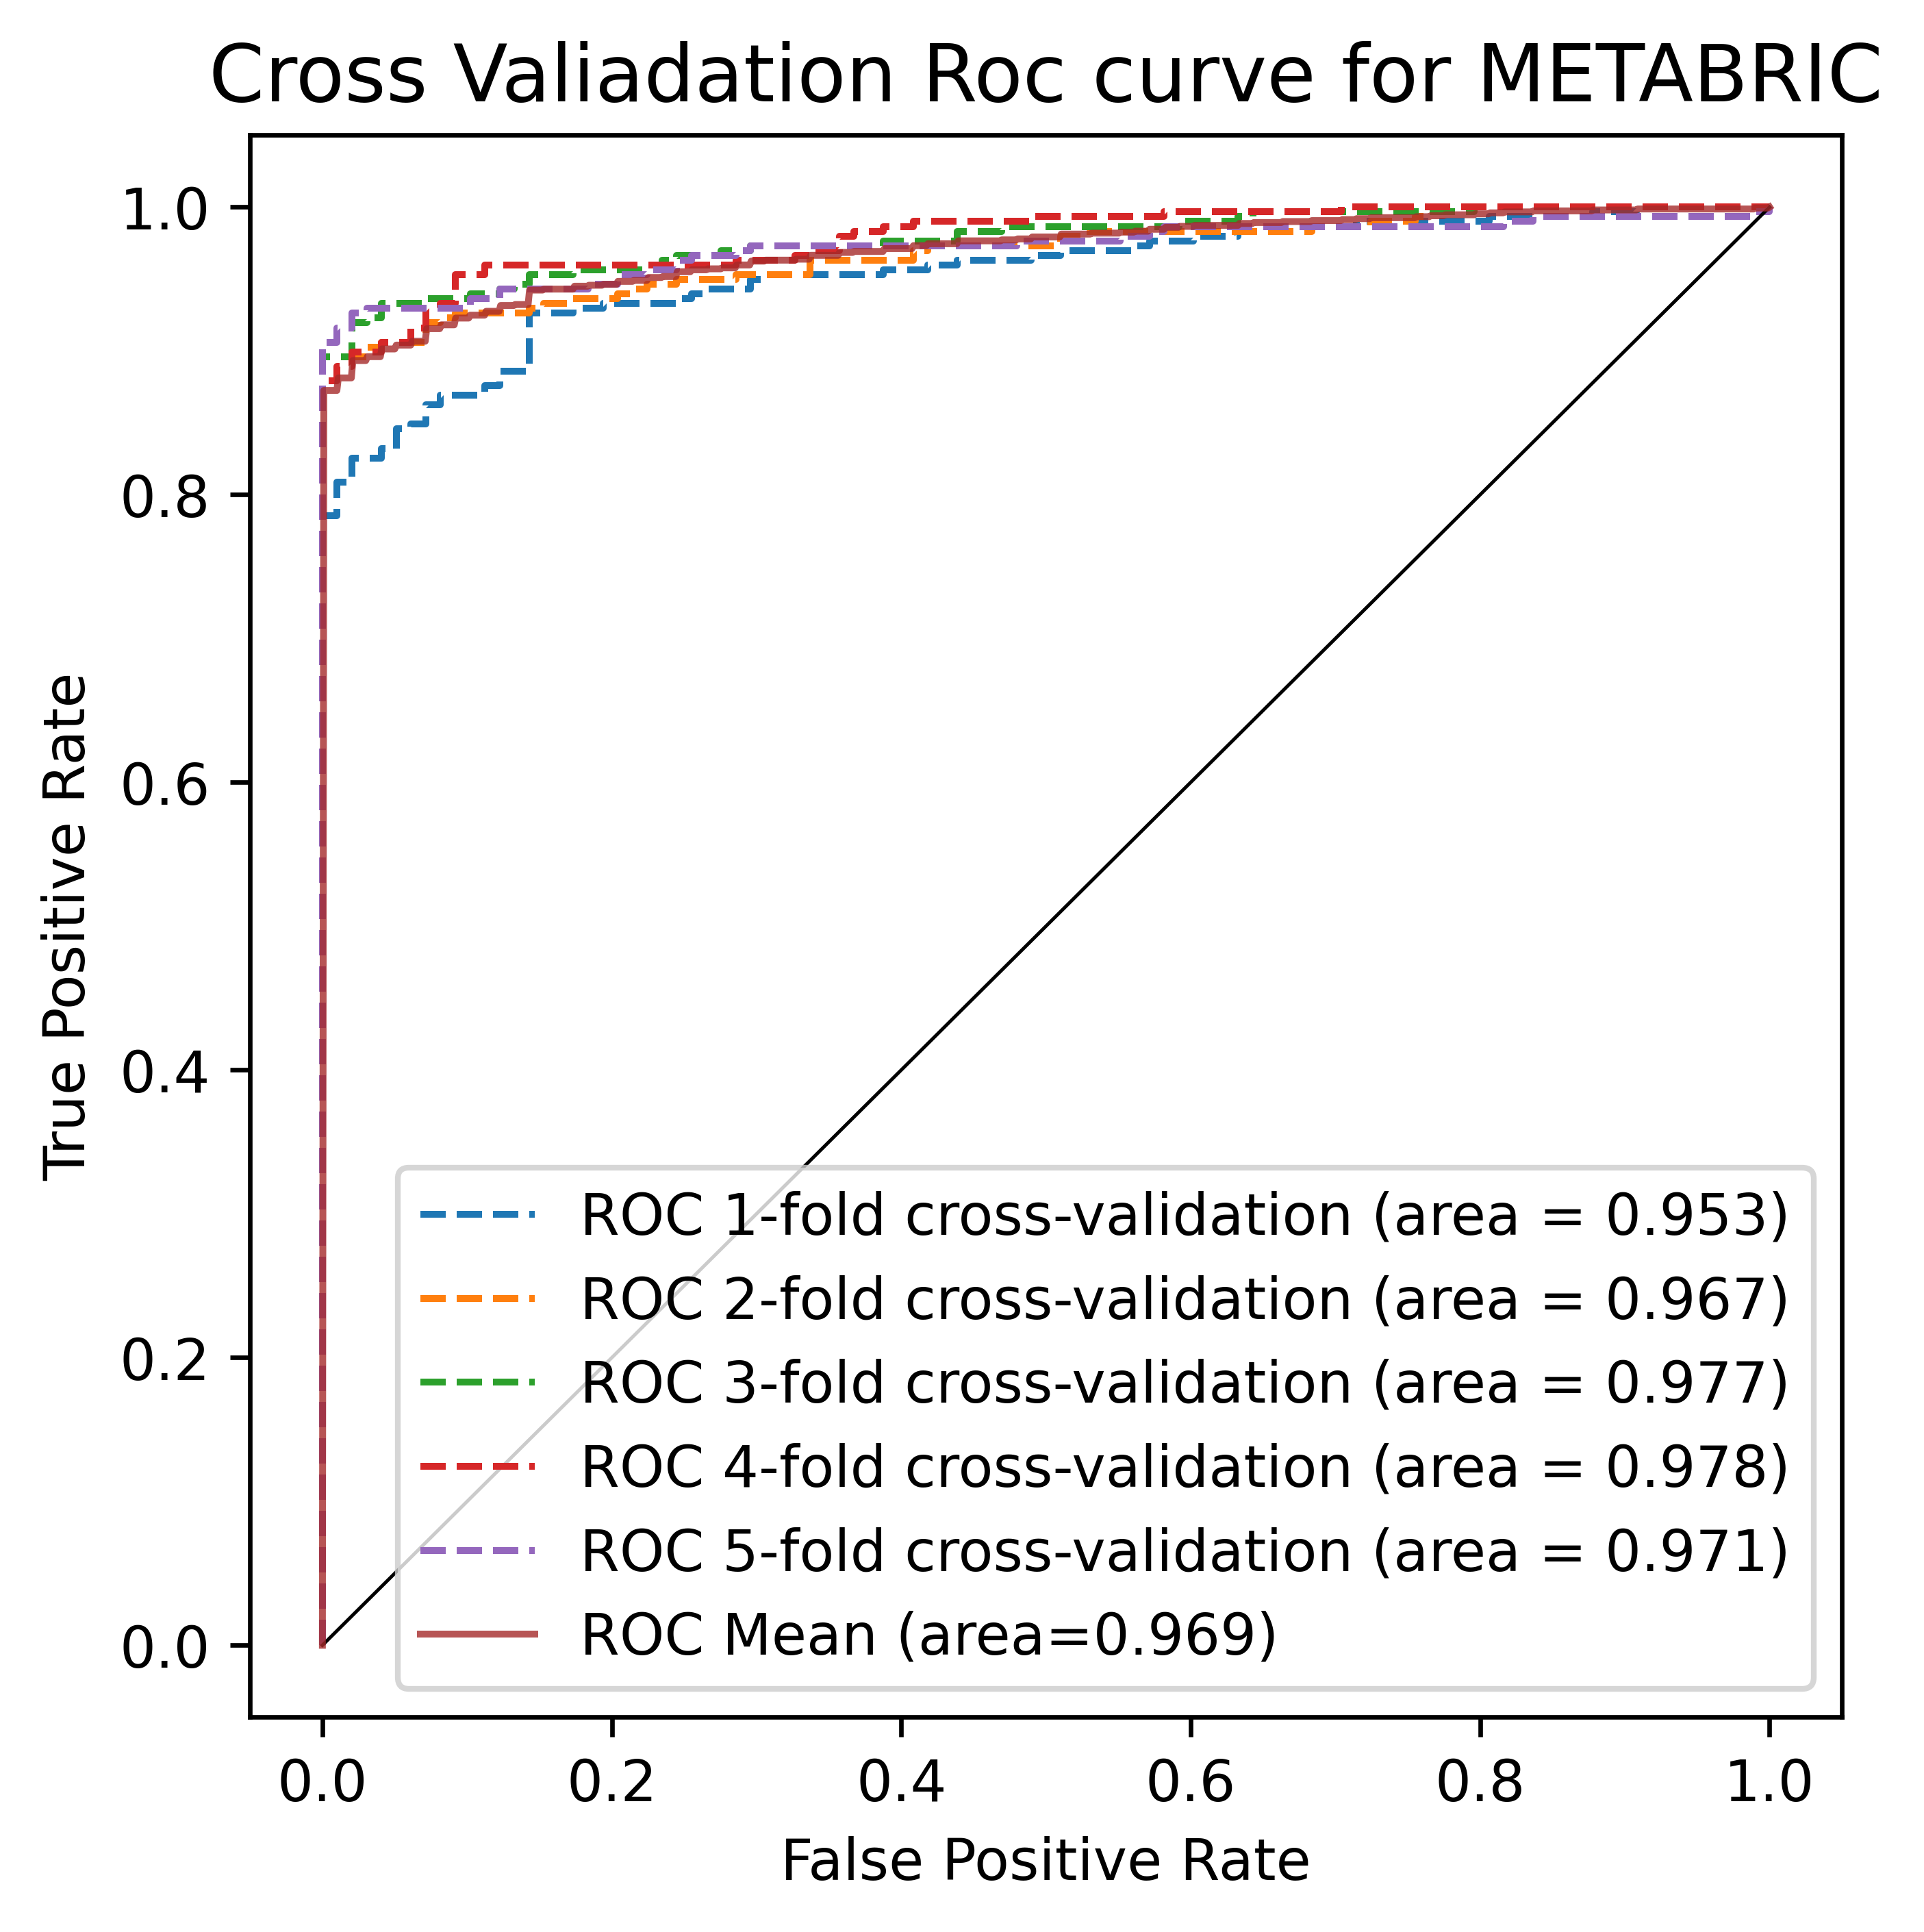

In [2]:
yt1 = torch.load('metabric/train_data/yt1.pkl')
y1 = torch.load('metabric/train_data/fake_prob1.pkl')
yt2 = torch.load('metabric/train_data/yt2.pkl')
y2 = torch.load('metabric/train_data/fake_prob2.pkl')
yt3 = torch.load('metabric/train_data/yt3.pkl')
y3 = torch.load('metabric/train_data/fake_prob3.pkl')
yt4 = torch.load('metabric/train_data/yt4.pkl')
y4 = torch.load('metabric/train_data/fake_prob4.pkl')
yt5 = torch.load('metabric/train_data/yt5.pkl')
y5 = torch.load('metabric/train_data/fake_prob5.pkl')

fig, ax2 = plt.subplots(figsize=(5, 5), dpi=600)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 1000)

labels = ['ROC 1-fold cross-validation', "ROC 2-fold cross-validation", "ROC 3-fold cross-validation"
    , "ROC 4-fold cross-validation", "ROC 5-fold cross-validation"]
for label, pred in zip(labels, [roc_curve(yt1, y1), roc_curve(yt2, y2), roc_curve(yt3, y3), roc_curve(yt4, y4),
                                roc_curve(yt5, y5)]):
    fpr, tpr, threshold = pred
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=label + ' (area = %0.3f)' % roc_auc, linewidth=1.2, linestyle="--")
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0

ax2.plot([0, 1], [0, 1], linewidth=0.6, color="black")
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)  # 计算平均AUC值
std_auc = np.std(tprs, axis=0)
torch.save(mean_tpr, 'metabric/trans_tpr.pkl')
torch.save(mean_fpr, 'metabric/trans_fpr.pkl')
torch.save(mean_auc, 'metabric/tran_auc.pkl')
ax2.plot(mean_fpr, mean_tpr, color='brown', label=r'ROC Mean (area=%0.3f)' % mean_auc, lw=1.2, alpha=.8)
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.legend(loc="lower right", prop={'size': 10})
ax2.set_title("Cross Valiadation Roc curve for METABRIC", fontsize=14)
plt.savefig('roc_metabric.png', dpi=600)
plt.savefig('roc_metabric.svg', dpi=600)

Text(0.5, 1.0, 'Cross Valiadation Roc curve for METABRIC')

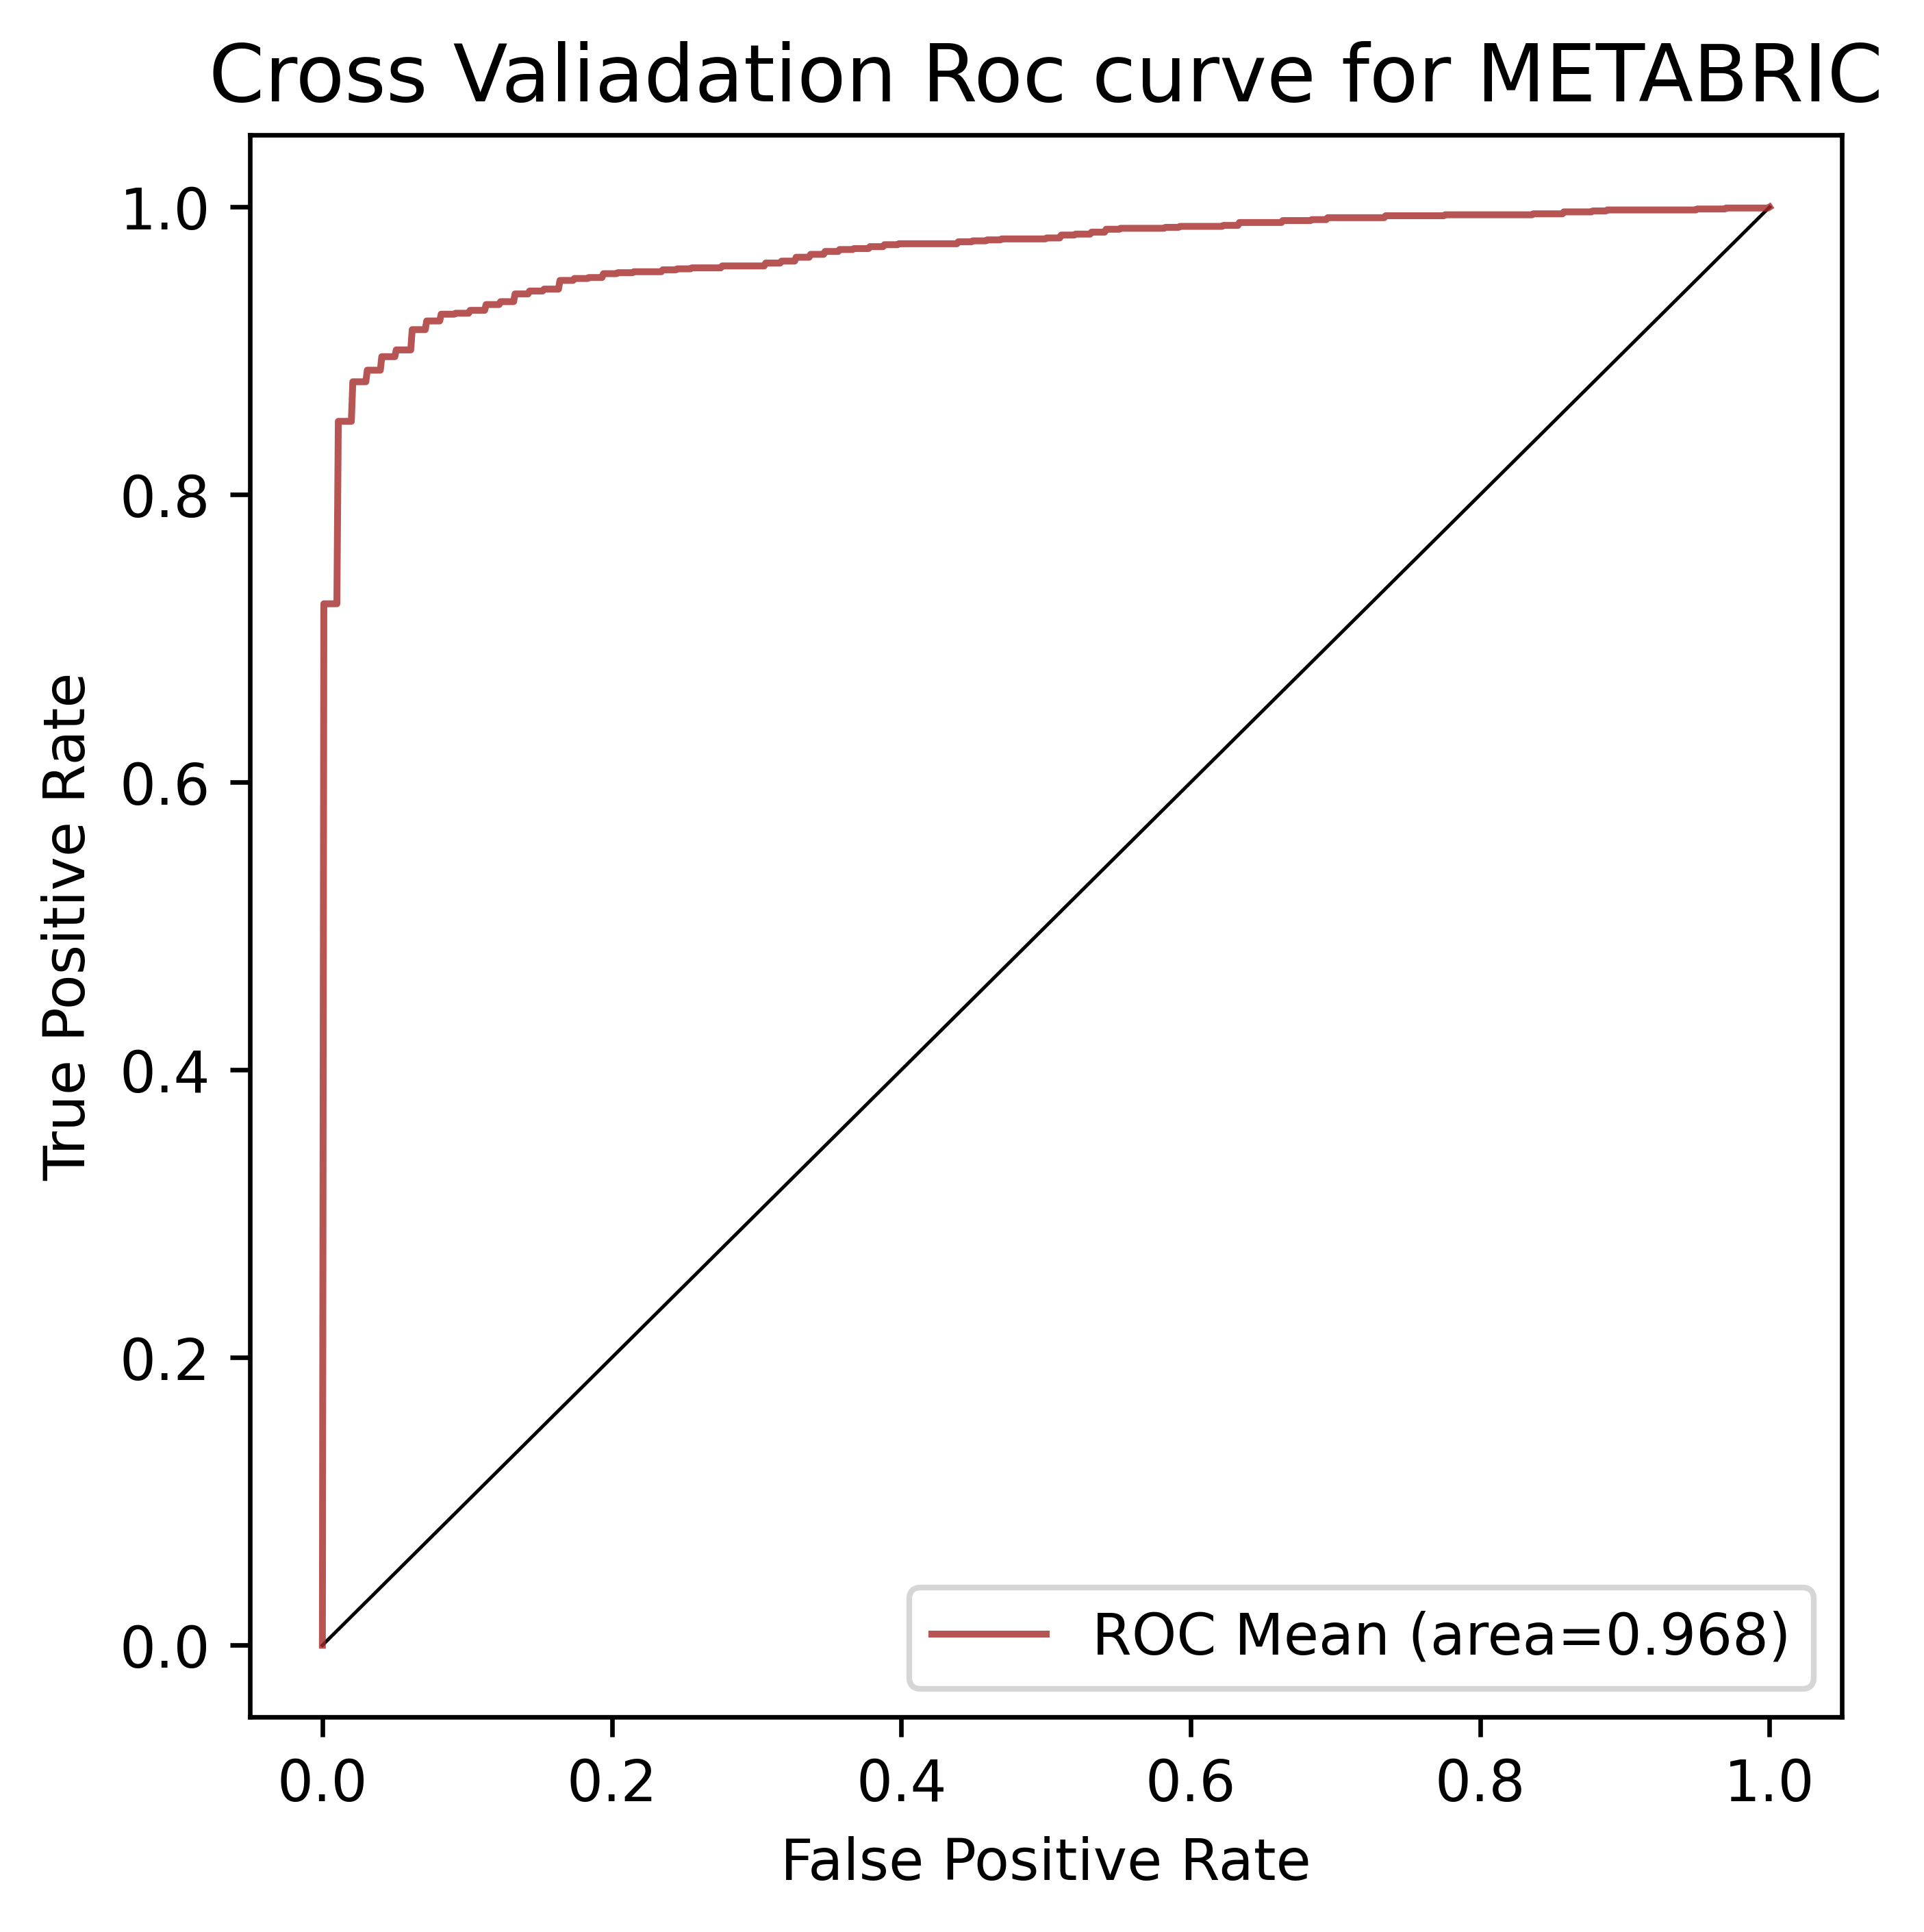

In [12]:
mean_tpr = torch.load('metabric/trans_tpr.pkl')
mean_fpr = torch.load('metabric/trans_fpr.pkl')
mean_auc = torch.load('metabric/tran_auc.pkl')
fig, ax = plt.subplots(figsize=(5, 5), dpi=600)
ax.plot([0, 1], [0, 1], linewidth=0.6, color="black")
ax.plot(mean_fpr, mean_tpr, color='brown', label=r'ROC Mean (area=%0.3f)' % mean_auc, lw=1.2, alpha=.8)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc="lower right", prop={'size': 10})
ax.set_title("Cross Valiadation Roc curve for METABRIC", fontsize=14)